Jose Penalver Bartolome

In [1]:
# import sys
# sys.path.append('/users/penal/appdata/local/programs/python/python39/lib/site-packages')

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

import numpy as np
from collections import deque, namedtuple
from gym.wrappers.monitoring import video_recorder

In [2]:
device = torch.device("cpu")
memory_size = int(1e5) 
batch_size = 64         
# gamma = 0.99           
# tau = 1e-3              
# lr = 5e-4               
update_freq = 4
seed = 0
env = gym.make('LunarLander-v2')
env.seed(seed)

[0]

In [13]:
class QNN(nn.Module):
    
    def __init__(self, states, actions, seed):
        super(QNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layers = nn.Sequential(
            nn.Linear(states, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, actions)
        )
        
    def forward(self, s):
        return self.layers(s)
        

In [14]:
class LearningAgent():
    
    def __init__(self, states, actions, lr, gamma, tau):
        self.states = states
        self.actions = actions
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.qnn_local = QNN(states, actions, seed).to(device)
        self.qnn_target = QNN(states, actions, seed).to(device)
        self.optimizer = optim.Adam(self.qnn_local.parameters(), lr=self.lr)
        
        self.memory = Memory(actions, memory_size, batch_size)
        self.t_step = 0
    
    def step(self, state, action, reward, new_state, terminated):
        self.memory.add(state, action, reward, new_state, terminated)
        self.t_step += 1
        self.t_step = self.t_step % update_freq
        if self.t_step == 0 and batch_size < len(self.memory):
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)
    
    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnn_local.eval()
        with torch.no_grad():
            actions_list = self.qnn_local(state)
        self.qnn_local.train()

        if random.random() > epsilon:
            return np.argmax(actions_list.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.actions))
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, terminates = experiences

        q_targets_next = self.qnn_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - terminates)
        q_expected = self.qnn_local(states).gather(1, actions)
        
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update(self.qnn_local, self.qnn_target)   
    def update(self, local, target):
#         Soft Update method
#         target = τ*local + (1 - τ)*target
        for target_param, local_param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [15]:
class Memory:
    def __init__(self, action_size, memory_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "terminate"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = []
        actions = []
        rewards = []
        next_states = []
        terminates = []
        
        for e in experiences:
            if e is not None:
                states.append(e.state)
                actions.append(e.action)
                rewards.append(e.reward)
                next_states.append(e.next_state)
                terminates.append(e.terminate)

        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        terminates = torch.from_numpy(np.vstack(terminates).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, terminates)

    def __len__(self):
        return len(self.memory)

In [16]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    rewards = []                       
    reward_sets = deque(maxlen=100) 
    eps = eps_start               
    for i in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminate, _ = env.step(action)
            agent.step(state, action, reward, next_state, terminate)
            state = next_state
            score += reward
            if terminate:
                break 
        eps = max(eps_end, eps_decay*eps)
        reward_sets.append(score)       
        rewards.append(score)
        mean_reward = np.mean(reward_sets)
        print('\r Episode {}      Average Score: {}'.format(i, mean_reward), end="")
        if np.mean(reward_sets)>=200.0:
            print('\n Environment solved in {} episodes.'.format(i-100))
            print("\n Average Score: {}".format(mean_reward))
            torch.save(agent.qnn_local.state_dict(), 'checkpoint.pth')
            break
    return rewards

agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-3)
rewards = train()

 Episode 613      Average Score: 201.340230710055043658
 Environment solved in 513 episodes.

 Average Score: 201.34023071005504


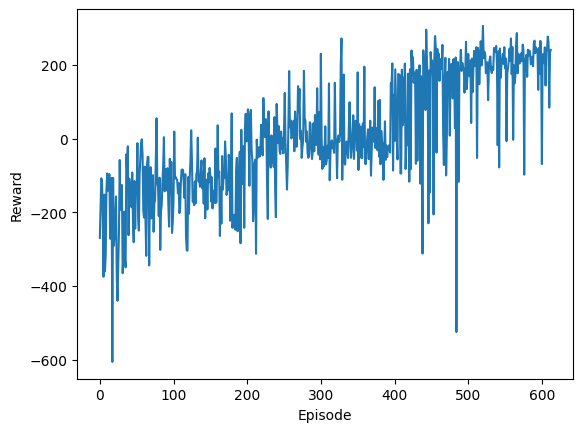

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [19]:
def get_trained_rewards(agent):
    env = gym.make("LunarLander-v2")
    agent.qnn_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    terminate = False
    rewards = []
    i = 0
    while i < 100:
#         env.render()
        action = agent.act(state, 0)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        i += 1
#     env.close()
    return rewards
rewards = get_trained_rewards(LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-3))

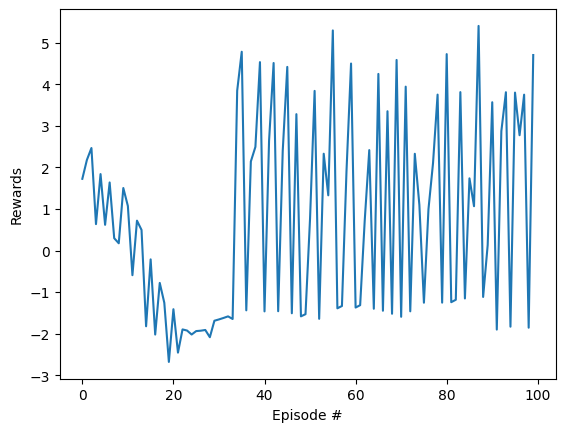

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Rewards')
plt.xlabel('Episode #')
plt.show()

**Learning Rate**

In [21]:
agent = LearningAgent(states=8, actions=4, lr=5e-2, gamma=.99, tau=1e-3)
lr1 = train()

 Episode 2000      Average Score: -200.97179892685375

In [22]:
agent = LearningAgent(states=8, actions=4, lr=5e-6, gamma=.99, tau=1e-3)
lr2 = train()

 Episode 2000      Average Score: -182.89327727643266

In [23]:
agent = LearningAgent(states=8, actions=4, lr=2.5e-4, gamma=.99, tau=1e-3)
lr4 = train()

 Episode 2000      Average Score: -133.02030468511584

In [24]:
agent = LearningAgent(states=8, actions=4, lr=7.5e-4, gamma=.99, tau=1e-3)
lr3 = train()

 Episode 731      Average Score: 201.869514544168482
 Environment solved in 631 episodes.

 Average Score: 201.86951454416848


In [36]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-3)
lr5 = train()

 Episode 657      Average Score: 200.024475268833539
 Environment solved in 557 episodes.

 Average Score: 200.02447526883353


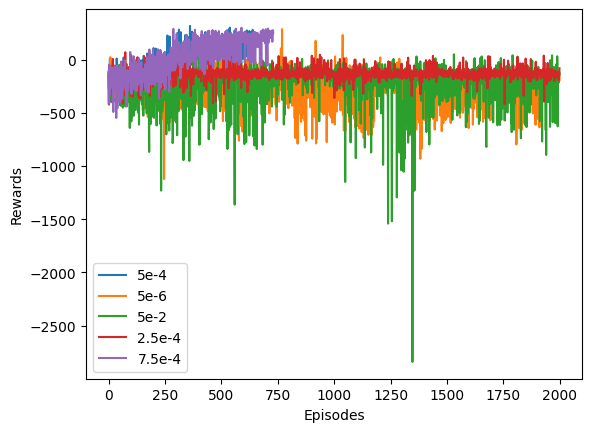

In [37]:
plt.plot(lr5, label="5e-4")
plt.plot(lr2, label="5e-6")
plt.plot(lr1, label="5e-2")
plt.plot(lr4, label="2.5e-4")
plt.plot(lr3, label="7.5e-4")
plt.legend()
plt.ylabel("Rewards")
plt.xlabel("Episodes")
plt.show()

**Gamma**

In [27]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.75, tau=1e-3)
g1 = train()

 Episode 2000      Average Score: 54.13534951334483478

In [28]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.5, tau=1e-3)
g2 = train()

 Episode 2000      Average Score: -14.7933996633087373

In [29]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.25, tau=1e-3)
g3 = train()

 Episode 2000      Average Score: -36.613056401325784

In [39]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-3)
g4 = train()

 Episode 792      Average Score: 200.871019878265432
 Environment solved in 692 episodes.

 Average Score: 200.87101987826543


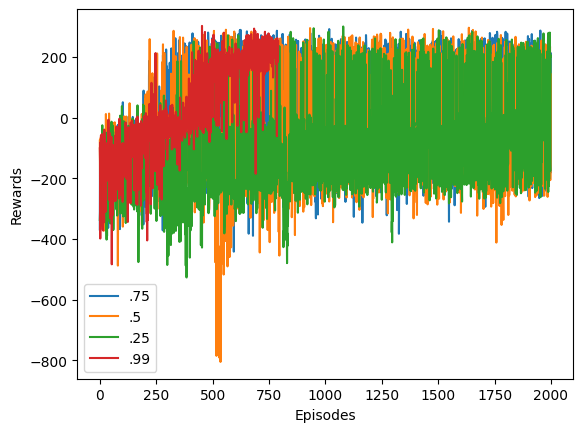

In [41]:
plt.plot(g1, label=".75")
plt.plot(g2, label=".5")
plt.plot(g3, label=".25")
plt.plot(g4, label=".99")
plt.legend()
plt.ylabel("Rewards")
plt.xlabel("Episodes")
plt.show()

**Tau**

In [42]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-1)
t1 = train()

 Episode 689      Average Score: 201.893982683033877324
 Environment solved in 589 episodes.

 Average Score: 201.89398268303387


In [43]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-5)
t2 = train()

 Episode 2000      Average Score: -79.458423991717034

In [44]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=5e-4)
t3 = train()

 Episode 1231      Average Score: 204.19237489715884
 Environment solved in 1131 episodes.

 Average Score: 204.1923748971588


In [45]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=2e-3)
t4 = train()

 Episode 1264      Average Score: 200.33668352940333
 Environment solved in 1164 episodes.

 Average Score: 200.33668352940333


In [46]:
agent = LearningAgent(states=8, actions=4, lr=5e-4, gamma=.99, tau=1e-3)
t5 = train()

 Episode 1012      Average Score: 200.307089511272474
 Environment solved in 912 episodes.

 Average Score: 200.30708951127247


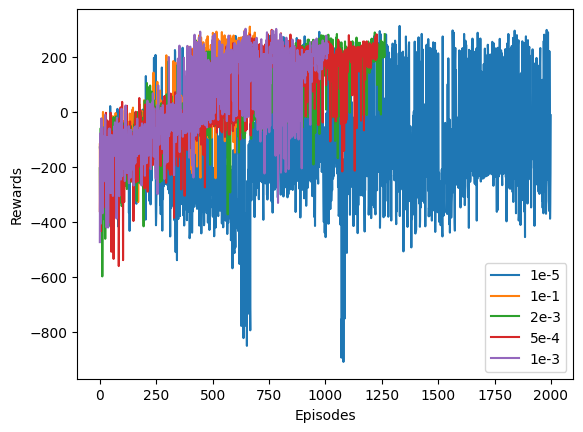

In [47]:
plt.plot(t2, label="1e-5")
plt.plot(t1, label="1e-1")
plt.plot(t4, label="2e-3")
plt.plot(t3, label="5e-4")
plt.plot(t5, label="1e-3")
plt.legend()
plt.ylabel("Rewards")
plt.xlabel("Episodes")
plt.show()